<a href="https://colab.research.google.com/github/mikislin/CNE25/blob/main/notebooks/CNE_Class3_QAB_DCL_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLabCut on Single Mouse Data Demo

👋 This notebook is a modified copy from [Github](https://colab.research.google.com/github/DeepLabCut/DeepLabCut/blob/master/examples/COLAB/COLAB_DEMO_mouse_openfield.ipynb), originally written by Mackenzie Mathis and contributors.

⚠️ It has been edited for the 2025 CNE class!


This notebook illustrates how to use DeepLabCut and Colab to:


This notebook illustrates how to use the cloud to:

- load demo data
- create a training set
- train a network
- evaluate a network
- analyze a novel video



Setup: Run on Colab with GPU (Runtime > Change runtime type > GPU).

In [ ]:
# Clone the entire deeplabcut repo so we can use the demo data:
!git clone -l -s https://github.com/DeepLabCut/DeepLabCut.git cloned-DLC-repo
%cd cloned-DLC-repo
!ls

Cloning into 'cloned-DLC-repo'...
remote: Enumerating objects: 26974, done.
remote: Counting objects: 100% (1496/1496), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 26974 (delta 1317), reused 1068 (delta 1064), pack-reused 25478 (from 3)
Receiving objects: 100% (26974/26974), 198.01 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (19020/19020), done.
/content/cloned-DLC-repo
AUTHORS		    deeplabcut	LICENSE		requirements.txt   tools
CODE_OF_CONDUCT.md  dlc.py	NOTICE.yml	setup.py
conda-environments  docker	pyproject.toml	tests
_config.yml	    docs	README.md	testscript_cli.py
CONTRIBUTING.md     examples	reinstall.sh	_toc.yml


In [ ]:
# Install the latest DeepLabCut version (this will take a few minutes to install all the dependencies!)
%cd /content/cloned-DLC-repo/
%pip install "."

/content/cloned-DLC-repo
Processing /content/cloned-DLC-repo
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 138.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18

### The installation error is expected after installing DLC on the colab
PLEASE, click "restart runtime" from the output above before proceeding!

In [ ]:
import deeplabcut

Loading DLC 3.0.0rc13...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [ ]:
print("DLC version:", deeplabcut.__version__)

DLC version: 3.0.0rc13


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from ipywidgets import interact, IntSlider
import os
import yaml
import numpy as np
from IPython.display import HTML
from base64 import b64encode

TensorFlow version: 2.19.0


In [ ]:
# @title Preview the experimental data

# Replace with the actual filename or full path
video_path = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/videos/m3v1mp4.mp4'

# Read the video file in binary mode
with open(video_path, 'rb') as f:
    mp4_bytes = f.read()

# Encode the video bytes to base64
mp4_base64 = b64encode(mp4_bytes).decode()

# Create the HTML for embedding the video
html_code = f"""
<video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{mp4_base64}" type="video/mp4">
    Your browser does not support the video tag.

</video>
"""

# Display the HTML
display(HTML(html_code))

In [ ]:
# @title Create a path variable that links to the config file:
path_config_file = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/config.yaml'

# Loading example data set:
deeplabcut.load_demo_data(path_config_file)

# Automatically update some hyperparameters for training,
# here rotations to +/- 180 degrees. This can be helpful for optimizing performance.
# see Primer -- Mathis et al. Neuron 2020
from deeplabcut.core.config import read_config_as_dict
import deeplabcut.pose_estimation_pytorch as dlc_torch

loader = dlc_torch.DLCLoader(
    config=path_config_file,
    trainset_index=0,
    shuffle=1,
)

# Get the pytorch config path
pytorch_config_path = loader.model_folder / "pytorch_config.yaml"

model_cfg = read_config_as_dict(pytorch_config_path)
model_cfg['data']["train"]["affine"]["rotation"]=180 # Augmentation for better generalization

# Save the modified config
dlc_torch.config.write_config(pytorch_config_path,model_cfg)

Loaded, now creating training data...


# Problem 1: Why is label quality crucial for Computer Vision model training?

DLC repo provides images with the labes, review them before starting training

In [ ]:
# @title Interactive Labeled Frames Review
csv_path = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.csv'
img_folder = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/'
df = pd.read_csv(csv_path, skiprows=2)
df.columns = ['img_path', 'snout_x', 'snout_y', 'leftear_x', 'leftear_y', 'rightear_x', 'rightear_y', 'tailbase_x', 'tailbase_y']

def plot_labeled_image(idx):
    row = df.iloc[idx]
    img_name = row['img_path'].split('/')[-1]
    img_path = os.path.join(img_folder, img_name)
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.scatter(row['snout_x'], row['snout_y'], c='r', s=50, label='Snout')
    ax.scatter(row['leftear_x'], row['leftear_y'], c='g', s=50, label='Left Ear')
    ax.scatter(row['rightear_x'], row['rightear_y'], c='b', s=50, label='Right Ear')
    ax.scatter(row['tailbase_x'], row['tailbase_y'], c='y', s=50, label='Tail Base')
    ax.legend()
    ax.set_title(f"Labeled Image: {img_name}")
    plt.show()

interact(plot_labeled_image, idx=IntSlider(min=0, max=len(df)-1, step=1, value=0, description='Image Index'))


interactive(children=(IntSlider(value=0, description='Image Index', max=115), Output()), _dom_classes=('widget…

<function __main__.plot_labeled_image(idx)>

reply here:

Bonus Problem: Illustrating the Impact of Label Quality on DLC Model Performance

Description:

To demonstrate why label quality is crucial in computer vision, modify the training labels in CollectedData_Pranav.csv to simulate corruption or shuffling.

Train the DLC model on the modified data and compare performance (e.g., mean likelihoods, accuracy) to the original. This illustrates that models can "learn" (memorize) even random labels with high train accuracy but fail to generalize, dropping test performance to near-zero

In [ ]:
# Load original CSV
gt_path = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav.csv'
df = pd.read_csv(gt_path, skiprows=2)
df.columns = ['img_path', 'snout_x', 'snout_y', 'leftear_x', 'leftear_y', 'rightear_x', 'rightear_y', 'tailbase_x', 'tailbase_y']

# Shuffle version
df_shuffled = df.copy()
df_shuffled.iloc[:,1:] = np.random.permutation(df_shuffled.iloc[:,1:].values)
df_shuffled.to_csv('/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav_shuffled.csv', index=False)

# Corrupted version
df_corrupted = df.copy()
df_corrupted.iloc[:,1:] += np.abs(np.random.normal(0, 5, df_corrupted.iloc[:,1:].shape))
df_corrupted.to_csv('/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/CollectedData_Pranav_corrupted.csv', index=False)

# Then, replace CSV in DLC folder and run training/analyze_videos

Creating training dataset for original variant...
Training dataset created for original at /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_original/config.yaml
Creating training dataset for corrupted variant...


Training with configuration:
data:
  bbox_margin: 20
  colormode: RGB
  inference:
    normalize_images: True
  train:
    affine:
      p: 0.5
      rotation: 30
      scaling: [0.5, 1.25]
      translation: 0
    crop_sampling:
      width: 448


Training dataset created for corrupted at /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_corrupted/config.yaml
Creating training dataset for shuffled variant...
Training dataset created for shuffled at /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_shuffled/config.yaml
Training original model...


      height: 448
      max_shift: 0.1
      method: hybrid
    gaussian_noise: 12.75
    motion_blur: True
    normalize_images: True
device: auto
inference:
  multithreading:
    enabled: True
    queue_length: 4
    timeout: 30.0
  compile:
    enabled: False
    backend: inductor
  autocast:
    enabled: False
metadata:
  project_path: /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_original
  pose_config_path: /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_original/dlc-models-pytorch/iteration-0/openfieldOct30-trainset95shuffle1/train/pytorch_config.yaml
  bodyparts: ['snout', 'leftear', 'rightear', 'tailbase']
  unique_bodyparts: []
  individuals: ['animal']
  with_identity: None
method: bu
model:
  backbone:
    type: ResNet
    model_name: resnet50_gn
    output_stride: 16
    freeze_bn_stats: False
    freeze_bn_weights: False
  backbone_output_channels: 2048
  heads:
    bodypart:
      type: HeatmapHead
      weight_init: normal
      predictor:


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

[timm/resnet50_gn.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Data Transforms:
  Training:   Compose([
  Affine(always_apply=False, p=0.5, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (0.5, 1.25), 'y': (0.5, 1.25)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}, rotate=(-30, 30), fit_output=False, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, cval_mask=0, keep_ratio=True, rotate_method='largest_box'),
  PadIfNeeded(always_apply=True, p=1.0, min_height=448, min_width=448, pad_height_divisor=None, pad_width_divisor=None, position=PositionType.CENTER, border_mode=0, value=None, mask_value=None),
  KeypointAwareCrop(always_apply=True, p=1.0, width=448, height=448, max_shift=0.1, crop_sampling='hybrid'),
  MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 7), allow_shifted=True),
  GaussNoise(always_apply=False, p=0.5, var_limit=(0, 162.5625), per_channel=True, mean=0),
  Nor

Training completed for original
Training corrupted model...


Loading pretrained weights from Hugging Face hub (timm/resnet50_gn.a1h_in1k)
[timm/resnet50_gn.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Data Transforms:
  Training:   Compose([
  Affine(always_apply=False, p=0.5, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (0.5, 1.25), 'y': (0.5, 1.25)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}, rotate=(-30, 30), fit_output=False, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, cval_mask=0, keep_ratio=True, rotate_method='largest_box'),
  PadIfNeeded(always_apply=True, p=1.0, min_height=448, min_width=448, pad_height_divisor=None, pad_width_divisor=None, position=PositionType.CENTER, border_mode=0, value=None, mask_value=None),
  KeypointAwareCrop(always_apply=True, p=1.0, width=448, height=448, max_shift=0.1, crop_sampling='hybrid'),
  MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 7), allow_shifted=True),
  GaussNoise(always_

Training completed for corrupted
Training shuffled model...


Loading pretrained weights from Hugging Face hub (timm/resnet50_gn.a1h_in1k)
[timm/resnet50_gn.a1h_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Data Transforms:
  Training:   Compose([
  Affine(always_apply=False, p=0.5, interpolation=1, mask_interpolation=0, cval=0, mode=0, scale={'x': (0.5, 1.25), 'y': (0.5, 1.25)}, translate_percent=None, translate_px={'x': (0, 0), 'y': (0, 0)}, rotate=(-30, 30), fit_output=False, shear={'x': (0.0, 0.0), 'y': (0.0, 0.0)}, cval_mask=0, keep_ratio=True, rotate_method='largest_box'),
  PadIfNeeded(always_apply=True, p=1.0, min_height=448, min_width=448, pad_height_divisor=None, pad_width_divisor=None, position=PositionType.CENTER, border_mode=0, value=None, mask_value=None),
  KeypointAwareCrop(always_apply=True, p=1.0, width=448, height=448, max_shift=0.1, crop_sampling='hybrid'),
  MotionBlur(always_apply=False, p=0.5, blur_limit=(3, 7), allow_shifted=True),
  GaussNoise(always_

Training completed for shuffled
Evaluating original model...
Evaluation scorer: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10


100%|██████████| 6/6 [00:00<00:00, 66.44it/s]


Evaluation results file: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv
Evaluation results for DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv (pcutoff: 0.4):
train rmse             3.27
train rmse_pcutoff     3.26
train mAP             94.25
train mAR             95.82
test rmse              2.37
test rmse_pcutoff      2.37
test mAP              97.49
test mAR              98.33
Name: (0.95, 1, 10, -1, 0.4), dtype: float64
Evaluating corrupted model...
Evaluation scorer: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10


100%|██████████| 6/6 [00:00<00:00, 43.73it/s]


Evaluation results file: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv
Evaluation results for DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv (pcutoff: 0.4):
train rmse             3.27
train rmse_pcutoff     3.26
train mAP             94.25
train mAR             95.82
test rmse              2.37
test rmse_pcutoff      2.37
test mAP              97.49
test mAR              98.33
Name: (0.95, 1, 10, -1, 0.4), dtype: float64
Evaluating shuffled model...
Evaluation scorer: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10


100%|██████████| 6/6 [00:00<00:00, 76.65it/s]


Evaluation results file: DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv
Evaluation results for DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-10-results.csv (pcutoff: 0.4):
train rmse             3.27
train rmse_pcutoff     3.26
train mAP             94.25
train mAR             95.82
test rmse              2.37
test rmse_pcutoff      2.37
test mAP              97.49
test mAR              98.33
Name: (0.95, 1, 10, -1, 0.4), dtype: float64


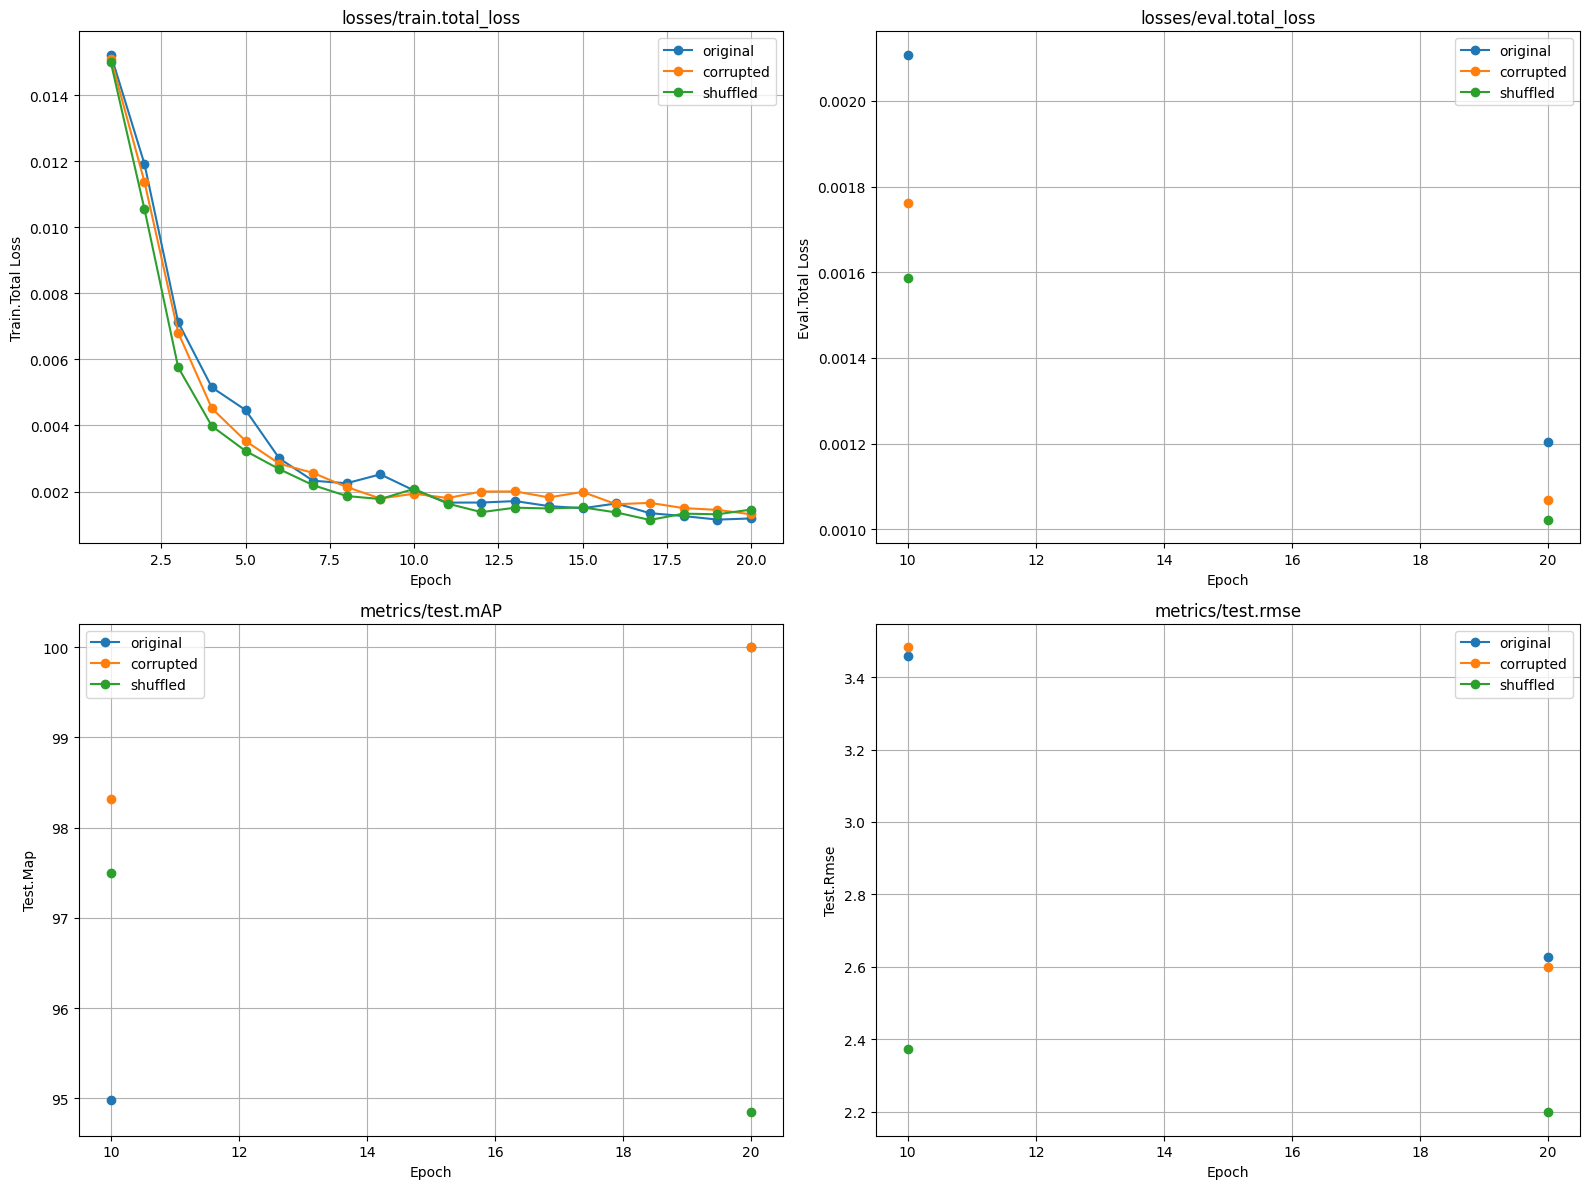

Side-by-Side Final Metrics:
                            original   corrupted   shuffled
losses/train.total_loss    0.001187    0.001312   0.001455
losses/eval.total_loss     0.001205    0.001069   0.001022
metrics/test.mAP         100.000000  100.000000  94.843234
metrics/test.rmse          2.627656    2.599131   2.197363


In [ ]:
import shutil
import deeplabcut
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import numpy as np
import glob
from IPython.display import display

# Section 3: Bonus - Simulate Label Corruption and Shuffling
base_label_dir = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/'
variants = ['original', 'corrupted', 'shuffled']
config_paths = {}

for variant in variants:
    model_dir = f'/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_{variant}/'
    os.makedirs(model_dir, exist_ok=True)
    config_path = os.path.join(model_dir, 'config.yaml')

    # Copy base config and update paths
    with open(path_config_file, 'r') as f:
        config = yaml.safe_load(f)
    config['project_path'] = model_dir
    labeled_data_dest = os.path.join(model_dir, 'labeled-data')
    os.makedirs(labeled_data_dest, exist_ok=True)
    shutil.copytree(base_label_dir, os.path.join(labeled_data_dest, 'm4s1'), dirs_exist_ok=True)

    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    config_paths[variant] = config_path

    # Generate variant labels
    label_csv_dest = os.path.join(labeled_data_dest, 'm4s1', f'CollectedData_Pranav_{variant}.csv')
    original_csv_path = os.path.join(base_label_dir, 'CollectedData_Pranav.csv')
    with open(original_csv_path, 'r') as f:
        header_lines = [f.readline() for _ in range(3)]

    df_variant = df.copy()
    if variant == 'shuffled':
        df_variant.iloc[:, 1:] = np.random.permutation(df_variant.iloc[:, 1:].values)
    elif variant == 'corrupted':
        df_variant.iloc[:, 1:] += np.abs(np.random.normal(0, 5, df_variant.iloc[:, 1:].shape))
    # Original keeps the original data

    with open(label_csv_dest, 'w') as f:
        f.writelines(header_lines)
        df_variant.to_csv(f, index=False, header=False)

    # Create training dataset and verify
    print(f"Creating training dataset for {variant} variant...")
    deeplabcut.create_training_dataset(config_path, net_type='resnet_50', augmenter_type='imgaug')
    print(f"Training dataset created for {variant} at {config_path}")

# Section 4: Training Function
def train_model(config_path, variant):
    print(f"Training {variant} model...")
    deeplabcut.train_network(
        config_path,
        shuffle=1,
        save_epochs=5,
        epochs=20,
        batch_size=8,
    )
    print(f"Training completed for {variant}")

# Train all variants
for variant, config_path in config_paths.items():
    train_model(config_path, variant)

# Section 5: Evaluation and Side-by-Side Comparison
def evaluate_and_plot(variants, config_paths):
    metrics_data = {}
    for variant in variants:
        print(f"Evaluating {variant} model...")
        deeplabcut.evaluate_network(config_path, plotting=False)  # Use latest snapshot
        model_folder_pattern = os.path.join(os.path.dirname(config_paths[variant]), 'dlc-models-pytorch/iteration-0/*/train/')
        model_folders = glob.glob(model_folder_pattern)
        if not model_folders:
            print(f"Warning: No model folder found for {variant} at {model_folder_pattern}")
            continue
        model_folder = model_folders[0]
        csv_path = os.path.join(model_folder, 'learning_stats.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            metrics_data[variant] = df
        else:
            print(f"Warning: {csv_path} not found")

    # Side-by-Side Plots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    metrics_to_plot = ['losses/train.total_loss', 'losses/eval.total_loss', 'metrics/test.mAP', 'metrics/test.rmse']
    for i, metric in enumerate(metrics_to_plot):
        ax = axs.flatten()[i]
        for variant, df in metrics_data.items():
            if metric in df.columns and not df.empty:
                ax.plot(df['step'], df[metric], label=variant, marker='o')
        ax.set_title(metric)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.split('/')[-1].replace('_', ' ').title())
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Table Comparison (Final Epoch Metrics)
    comparison_data = {}
    for variant, df in metrics_data.items():
        if not df.empty:
            last_row = df.iloc[-1]
            comparison_data[variant] = {metric: last_row.get(metric, 'N/A') for metric in metrics_to_plot}
        else:
            comparison_data[variant] = {metric: 'N/A' for metric in metrics_to_plot}
    comparison_df = pd.DataFrame(comparison_data)
    print("Side-by-Side Final Metrics:\n", comparison_df.round(6))

evaluate_and_plot(variants, config_paths)

In [ ]:
import shutil
import deeplabcut
import pandas as pd
import matplotlib.pyplot as plt
import os
import yaml
import numpy as np
import glob
from IPython.display import display

# Set random seed for reproducibility
np.random.seed(42)

# Section 3: Simulate Label Corruption and Shuffling
base_label_dir = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/labeled-data/m4s1/'
variants = ['original', 'corrupted', 'shuffled']
config_paths = {}

for variant in variants:
    model_dir = f'/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30_{variant}/'
    os.makedirs(model_dir, exist_ok=True)
    config_path = os.path.join(model_dir, 'config.yaml')

    # Clear old model data to ensure isolation
    shutil.rmtree(os.path.join(model_dir, 'dlc-models-pytorch'), ignore_errors=True)

    # Copy base config and update paths
    with open(path_config_file, 'r') as f:
        config = yaml.safe_load(f)
    config['project_path'] = model_dir
    labeled_data_dest = os.path.join(model_dir, 'labeled-data')
    os.makedirs(labeled_data_dest, exist_ok=True)
    shutil.copytree(base_label_dir, os.path.join(labeled_data_dest, 'm4s1'), dirs_exist_ok=True)

    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    config_paths[variant] = config_path

    # Generate variant labels with sanity check
    label_csv_dest = os.path.join(labeled_data_dest, 'm4s1', f'CollectedData_Pranav_{variant}.csv')
    original_csv_path = os.path.join(base_label_dir, 'CollectedData_Pranav.csv')
    with open(original_csv_path, 'r') as f:
        header_lines = [f.readline() for _ in range(3)]
    df = pd.read_csv(original_csv_path, skiprows=3, header=None)
    df_variant = df.copy()
    if variant == 'shuffled':
        df_variant.iloc[:, 1:] = np.random.permutation(df_variant.iloc[:, 1:].values)
    elif variant == 'corrupted':
        df_variant.iloc[:, 1:] += np.random.normal(0, 20, df_variant.iloc[:, 1:].shape)  # Increased noise
    with open(label_csv_dest, 'w') as f:
        f.writelines(header_lines)
        df_variant.to_csv(f, index=False, header=False)
    # Verify the first row
    df_check = pd.read_csv(label_csv_dest, skiprows=3, header=None)
    print(f"{variant} first row coordinates: {df_check.iloc[0, 1:5].values}")

    # Create training dataset with minimal augmentation for label quality demo
    print(f"Creating training dataset for {variant} variant...")
    deeplabcut.create_training_dataset(config_path, net_type='resnet_50', augmenter_type='default')
    print(f"Training dataset created for {variant} at {config_path}")

# Section 4: Training Function
def train_model(config_path, variant, max_epochs=20):
    print(f"Training {variant} model for {max_epochs} epochs...")
    deeplabcut.train_network(
        config_path,
        shuffle=1,
        save_epochs=5,
        epochs=max_epochs,
        batch_size=8,
        display_iters=1,  # Detailed logging
    )
    # Log the path to learning_stats.csv
    proj_root = os.path.dirname(config_path)
    stats_pattern = os.path.join(proj_root, "dlc-models-pytorch", "iteration-0", "*", "train", "learning_stats.csv")
    stats_files = glob.glob(stats_pattern)
    if stats_files:
        print(f"Learning stats saved at: {max(stats_files, key=os.path.getmtime)}")
    print(f"Training completed for {variant}")

# Train all variants
for variant, config_path in config_paths.items():
    train_model(config_path, variant)

# Section 5: Evaluation and Side-by-Side Comparison
def evaluate_and_plot(variants, config_paths):
    metrics_data = {}
    for variant in variants:
        cfg = config_paths[variant]
        print(f"Evaluating {variant} model with config {cfg}")
        deeplabcut.evaluate_network(cfg, plotting=False)

        # Build the path to the latest learning_stats.csv
        proj_root = os.path.dirname(cfg)
        stats_pattern = os.path.join(proj_root, "dlc-models-pytorch", "iteration-0", "*", "train", "learning_stats.csv")
        stats_files = glob.glob(stats_pattern)
        if not stats_files:
            print(f"No learning_stats.csv for {variant}")
            continue
        csv_path = max(stats_files, key=os.path.getmtime)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            metrics_data[variant] = df
        else:
            print(f"Warning: {csv_path} not found")

    # Side-by-Side Plots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    metrics_to_plot = ['losses/train.total_loss', 'losses/eval.total_loss', 'metrics/test.mAP', 'metrics/test.rmse']
    for i, col in enumerate(metrics_to_plot):
        ax = axs.flatten()[i]
        for variant, df in metrics_data.items():
            if col in df.columns and not df.empty:
                ax.plot(df['step'], df[col], label=variant, marker='o')
        ax.set_title(col)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(col.split('/')[-1].replace('_', ' ').title())
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

    # Table Comparison
    comparison_data = {}
    for variant, df in metrics_data.items():
        if not df.empty:
            last_row = df.iloc[-1]
            comparison_data[variant] = {metric: last_row.get(metric, 'N/A') for metric in metrics_to_plot}
        else:
            comparison_data[variant] = {metric: 'N/A' for metric in metrics_to_plot}
    comparison_df = pd.DataFrame(comparison_data)
    print("Side-by-Side Final Metrics:\n", comparison_df.round(6))

evaluate_and_plot(variants, config_paths)

## Start training:
This function trains the network for a specific shuffle of the training dataset.

In [ ]:
# Let's also change the display and save_epochs just in case Colab takes away
# the GPU... If that happens, you can reload from a saved point using the
# `snapshot_path` argument to `deeplabcut.train_network`:
#   deeplabcut.train_network(..., snapshot_path="/content/.../snapshot-050.pt")

# Typically, you want to train to ~200 epochs. We set the batch size to 8 to
# utilize the GPU's capabilities.

# More info and there are more things you can set:
#   https://deeplabcut.github.io/DeepLabCut/docs/standardDeepLabCut_UserGuide.html#g-train-the-network

deeplabcut.train_network(
    path_config_file,
    shuffle=1,
    save_epochs=5,
    epochs=1000,
    batch_size=8,
)

# This will run until you stop it (CTRL+C), or hit "STOP" icon, or when it hits the end.

Training with configuration:
data:
  bbox_margin: 20
  colormode: RGB
  inference:
    normalize_images: True
  train:
    affine:
      p: 0.5
      rotation: 180
      scaling: [0.5, 1.25]
      translation: 0
    crop_sampling:
      width: 448
      height: 448
      max_shift: 0.1
      method: hybrid
    gaussian_noise: 12.75
    motion_blur: True
    normalize_images: True
device: auto
inference:
  multithreading:
    enabled: True
    queue_length: 4
    timeout: 30.0
  compile:
    enabled: False
    backend: inductor
  autocast:
    enabled: False
metadata:
  project_path: /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30
  pose_config_path: /content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/dlc-models-pytorch/iteration-0/openfieldOct30-trainset95shuffle1/train/pytorch_config.yaml
  bodyparts: ['snout', 'leftear', 'rightear', 'tailbase']
  unique_bodyparts: []
  individuals: ['animal']
  with_identity: None
method: bu
model:
  backbone:
    type: ResNet

In [ ]:
# @ title Inspect the network training
# Adjust path to learning_stats.csv (from DLC model folder)
model_folder = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/dlc-models-pytorch/iteration-0/openfieldOct30-trainset95shuffle1/train/'
csv_path = os.path.join(model_folder, 'learning_stats.csv')

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Error: learning_stats.csv not found. Ensure training completed successfully.")
    raise

# Figure with subplots for losses
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot training losses
axs[0].plot(df['step'], df['losses/train.bodypart_heatmap'], label='Train Heatmap Loss', marker='o')
axs[0].plot(df['step'], df['losses/train.bodypart_locref'], label='Train Locref Loss', marker='o')
axs[0].plot(df['step'], df['losses/train.bodypart_total_loss'], label='Train Bodypart Total Loss', marker='o')
axs[0].plot(df['step'], df['losses/train.total_loss'], label='Train Total Loss', marker='o', linewidth=2)
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Losses over Epochs')
axs[0].legend()
axs[0].grid(True)

# Plot evaluation losses (only where available)
eval_df = df.dropna(subset=['losses/eval.total_loss'])
axs[1].plot(eval_df['step'], eval_df['losses/eval.bodypart_heatmap'], label='Eval Heatmap Loss', marker='s')
axs[1].plot(eval_df['step'], eval_df['losses/eval.bodypart_locref'], label='Eval Locref Loss', marker='s')
axs[1].plot(eval_df['step'], eval_df['losses/eval.bodypart_total_loss'], label='Eval Bodypart Total Loss', marker='s')
axs[1].plot(eval_df['step'], eval_df['losses/eval.total_loss'], label='Eval Total Loss', marker='s', linewidth=2)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Evaluation Losses at Checkpoints')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Separate plot for metrics
metric_fig, metric_ax = plt.subplots(figsize=(12, 6))
eval_metrics = df.dropna(subset=['metrics/test.mAP'])
metric_ax.plot(eval_metrics['step'], eval_metrics['metrics/test.mAP'], label='Test mAP (%)', marker='o')
metric_ax.plot(eval_metrics['step'], eval_metrics['metrics/test.mAR'], label='Test mAR (%)', marker='o')
# Twin axis for RMSE (different scale)
rmse_ax = metric_ax.twinx()
rmse_ax.plot(eval_metrics['step'], eval_metrics['metrics/test.rmse'], label='Test RMSE (pixels)', marker='o', color='r')
rmse_ax.plot(eval_metrics['step'], eval_metrics['metrics/test.rmse_pcutoff'], label='Test RMSE (pcutoff, pixels)', marker='o', color='m')
rmse_ax.set_ylabel('RMSE Value')
metric_ax.set_xlabel('Epoch')
metric_ax.set_ylabel('mAP/mAR Value')
metric_ax.set_title('Evaluation Metrics over Epochs')
metric_ax.legend(loc='upper left')
rmse_ax.legend(loc='upper right')
metric_ax.grid(True)
plt.show()

print("Review: Analyze if train/eval losses are decreasing without divergence (overfitting if eval rises while train drops). Metrics like mAP/mAR should increase, RMSE decrease. If metrics plateau, consider more epochs or hyperparameter tuning.")

## Start evaluating:
This function evaluates a trained model for a specific shuffle/shuffles at a particular state or all the states on the data set (images)
and stores the results as .csv file in a subdirectory under **evaluation-results**

In [ ]:
deeplabcut.evaluate_network(path_config_file, plotting=True)

# Here you want to see a low pixel error! Of course, it can only be as
# good as the labeler, so be sure your labels are good!a

# Problem 2: What metrics indicate good training?

reply here:

## Start Analyzing videos:
This function analyzes the new video. The user can choose the best model from the evaluation results and specify the correct snapshot index for the variable **snapshotindex** in the **config.yaml** file. Otherwise, by default the most recent snapshot is used to analyse the video.

The results are stored in hd5 file in the same directory where the video resides.

**On the demo data, this should take around ~ 90 seconds! (The demo frames are 640x480, which should run around 25 FPS on the google-provided T4 GPU)**

In [ ]:
# Enter the list of videos to analyze.
videofile_path = ["/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/videos/m3v1mp4.mp4"]
deeplabcut.analyze_videos(path_config_file, videofile_path, videotype=".mp4")

In [ ]:
deeplabcut.create_labeled_video(path_config_file, videofile_path)

In [ ]:
deeplabcut.create_labeled_video(
    path_config_file,
    videofile_path,
    videotype='mp4',
    filtered=False
)

In [ ]:
deeplabcut.plot_trajectories(path_config_file, videofile_path)

# Problem 3: Evaluate predictions

1. Inspect the likelihood-over-time plot (plot-likelihood.png in the plot-poses folder).

2. Adapt the code to load the HDF5 output file generated by deeplabcut.analyze_videos.

3. Extract likelihood values for each body part, and visualize their distributions using histograms and kernel density estimates (KDEs).

Address the following questions:
Which body part has the lowest mean likelihood?
What percentage of frames show low likelihoods ?

Based on both the distributions and the likelihood-over-time plot, propose at least two targeted improvements to the DLC model (for example, adding specific viewpoints to the training set, refining labels for difficult frames, or increasing model iterations).

In [ ]:
# Adjust path to predictions HDF5 file, see output of deeplabcut.analyze_videos line with "Saving results in "
h5_path = '/content/cloned-DLC-repo/examples/openfield-Pranav-2018-10-30/videos/m3v1mp4DLC_Resnet50_openfieldOct30shuffle1_snapshot_best-20.h5'

# Load predictions from HDF5
try:
    data = pd.read_hdf(h5_path)
    scorer = data.columns.levels[0][0]
    bodyparts = ['snout', 'leftear', 'rightear', 'tailbase']
    likelihood_columns = [(scorer, bp, 'likelihood') for bp in bodyparts]
    if not all(col in data.columns for col in likelihood_columns):
        print(f"Warning: Expected likelihood columns {likelihood_columns} not found. Available columns: {list(data.columns)}")
        raise ValueError("Missing expected columns in HDF5 file.")
except FileNotFoundError:
    print(f"Error: HDF5 file not found at {h5_path}. Ensure deeplabcut.analyze_videos ran successfully.")
    raise
except Exception as e:
    print(f"Unexpected error loading HDF5: {e}. Inspect with: h5py.File('{h5_path}', 'r').keys()")
    raise

In [ ]:
# solution

### Bonus: DCL Network Architecture

In [ ]:
# Optional: Graphical visualization with torchviz
print("\nGenerating graphical visualization of the model architecture...")
try:
    # Install dependencies
    %pip install --quiet torchviz graphviz
    # Install Graphviz binary for Colab (only if needed)
    !if ! command -v dot >/dev/null 2>&1; then apt-get update -qq && apt-get install -y graphviz; fi
    from torchviz import make_dot
    import os
    from IPython.display import Image, display
    import torch
    import deeplabcut.pose_estimation_pytorch as dlc_torch
    from deeplabcut.core.config import read_config_as_dict

    # Load model configuration
    pytorch_config_path = loader.model_folder / "pytorch_config.yaml"
    model_cfg = read_config_as_dict(pytorch_config_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model using DLC's training loader
    try:
        # Attempt to load the model using DLC's internal utilities
        from deeplabcut.pose_estimation_pytorch.training import PoseTrainingRunner
        runner = PoseTrainingRunner(
            config=pytorch_config_path,
            trainset_index=0,
            shuffle=1,
        )
        model = runner.model.to(device)
    except (AttributeError, ImportError) as e:
        print(f"Error initializing model: {e}")
        print("Model loading failed. Falling back to configuration-based description.")
        model = None

    if model:
        # Create dummy input for forward pass
        x = torch.randn(1, 3, 448, 448).to(device)  # Input size: batch=1, channels=3, 448x448 (from train.txt)

        # Perform forward pass
        y = model(x)

        # Generate and save visualization
        output_dir = loader.model_folder
        os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
        output_path = os.path.join(output_dir, "model_architecture")
        dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
        dot.format = 'png'
        dot.render(output_path, view=False)  # Save as PNG without opening

        # Verify and display output
        output_file = f"{output_path}.png"
        if os.path.exists(output_file):
            print(f"Graphical model architecture saved as {output_file}")
            display(Image(filename=output_file))
            print("Download the PNG from Colab's file explorer (left sidebar) under the model folder.")
        else:
            print(f"Warning: Output file {output_file} not found. Rendering may have failed.")
            print("Fallback: Displaying graph as text representation...")
            print(dot)
    else:
        # Fallback: Describe architecture from configuration
        print("\nFallback: Model visualization failed. Describing architecture from configuration:")
        print(f"Network Type: {model_cfg.get('net_type', 'N/A')}")
        print(f"Backbone: {model_cfg['model']['backbone']['type']} ({model_cfg['model']['backbone']['model_name']})")
        print(f"Bodyparts: {model_cfg['metadata']['bodyparts']}")
        print(f"Number of Keypoints: {len(model_cfg['metadata']['bodyparts'])}")
        print(f"Input Size: 448x448 (from crop_sampling)")
        print(f"Output: Heatmaps ({model_cfg['model']['heads']['bodypart']['heatmap_config']['channels'][-1]} channels) and location refinements for {len(model_cfg['metadata']['bodyparts'])} keypoints")
        print(f"Location Refinement Std: {model_cfg['model']['heads']['bodypart']['locref_std']}")
        print("Note: The model uses a ResNet50 backbone for feature extraction, followed by a heatmap head (predicting keypoint probabilities) and a location refinement head (refining coordinates).")

    print("Review: If visualized, inspect the network graph to identify the ResNet50 backbone, heatmap head, and location refinement head. How do ResNet50’s convolutional layers capture spatial features for mouse tracking? Why are separate heads used for heatmaps and location refinement in pose estimation for bodyparts (snout, leftear, rightear, tailbase)? If visualization failed, use the configuration details to infer the model structure. How does the 448x448 input size balance detail and computational cost? Consider checking the DLC version or re-running '%pip install deeplabcut --upgrade'.")

except ImportError as e:
    print(f"Error: Failed to import torchviz, graphviz, or DLC modules: {e}")
    print("Run '%pip install torchviz graphviz deeplabcut --upgrade' in a new cell.")
except NameError as e:
    print(f"Error: Variable not defined: {e}")
    print("Ensure 'loader' is defined. Check if deeplabcut.create_training_dataset was run successfully.")
except RuntimeError as e:
    print(f"Error during forward pass: {e}")
    print("Verify model initialization, CUDA availability, and input size (448x448). Try re-running the model setup.")
except OSError as e:
    print(f"Error with Graphviz binary: {e}")
    print("Run '!apt-get install graphviz' in a new cell. Verify 'dot' is in PATH with '!which dot'.")
except Exception as e:
    print(f"Unexpected error: {e}")
    print("Try re-running the cell or installing dependencies manually ('%pip install torchviz graphviz deeplabcut --upgrade' and '!apt-get install graphviz').")